# Recommender System

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Data Loading

First we load the datasets we will use throughout this assignment. We will train our model using the train dataset. For the NMF part of the assignment we aim to find a combination of number of components and iterations that minimizes the error while also being able to complete in an acceptable timeframe. Meanwhile, for the minhashing part, we aim to (PAUL).

In [2]:
train_file_path = "lab2_train.csv"
test_file_path = "lab2_test.csv"

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

### Non-Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization (NMF) is an algorithm employed in dimensionality reduction and feature extraction used in machine learning and data analysis. NMF imposes the constraint that both the input matrix and the factors it is decomposed into must have non-negative elements. This constraint leads to a factorization that is often more interpretable and can be particularly useful when dealing with datasets where negative values may not have meaningful interpretations.

Mathematically, given a non-negative matrix V, NMF factorizes it into W×H, where W and H are non-negative matrices, and W contains the basis vectors, while H contains the coefficients.

The NMF algorithm is iterative and aims to minimize the difference (computed via a loss function) between the original matrix and the reconstructed matrix obtained from the product of W and H. The factors W and H are updated iteratively until a desired threshold has been achieved.

Note that our version has been slightly modified to allow for the use of masks to handle incorrect data (eg. NaN values).

In [3]:
def nmf(X: pd.DataFrame, n_components: int, max_iter: int=1000, tol: float=1e-3):
  """
  Decomposes the original sparse matrix X into two matrices W and H. 
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])
  
  V = X.fillna(0).values
  # START ANSWER
  mask = (~np.isnan(X)).astype(float).values
  
  epsilon = 1e-9
  E = np.linalg.norm((V - (W @ H)) * mask)**2

  for i in range(max_iter):
    H = H * (W.T @ (V * mask)) / ((W.T @ (W @ H)) + epsilon)
    W = W * ((V * mask) @ H.T) / (((W @ H) @ H.T) + epsilon)
    
    E_new = np.linalg.norm((V - (W @ H)) * mask)**2
    
    # Auxiliary used for progress estimation
    percent = (i + 1) / max_iter * 100
    print(f'{percent:.2f}%', end='\r')

    if E - E_new < tol :
      return W, H
      
  # END ANSWER
  return W, H, E_new

### Familiarization

What follows are various representations of our dataset to better familiarize ourselves with it. Explanations will be given above/below each plot/matrix.

Let's start with simply printing our train dataset

In [4]:
train_data

,user_from_id,user_to_id,is_like,is_match
0,1136,3141,False,False
1,2424,3174,False,False
2,1300,3590,False,False
3,800,2736,False,False
4,883,437,False,False
...,...,...,...,...
76387,2376,3057,False,False
76388,1163,933,False,False
76389,2770,3324,False,False
76390,879,785,False,False


In [5]:
train_data["is_match"].value_counts()

is_match
False    75162
True       415
Name: count, dtype: int64

Our data has four columns: the first two represent user IDs, the third represents whether the user in the first column liked the one in the second, and the fourth represents whether the users liked each other.

We can see that in the "is_match" column, the overwhelming majority of values are False. As was mentioned in the assignment document, matches are very rare, so we will focus only on the thrid column, the "like / don't like" feature. 

Because of this we have chosen to remove the "is_match" column from our dataset.

In [6]:
train_data.drop(columns = "is_match", inplace = True)
train_data

,user_from_id,user_to_id,is_like
0,1136,3141,False
1,2424,3174,False
2,1300,3590,False
3,800,2736,False
4,883,437,False
...,...,...,...
76387,2376,3057,False
76388,1163,933,False
76389,2770,3324,False
76390,879,785,False


We move and examine the distribution of likes and dislikes in our dataset.

The following pie chart showcases the distribution of "likes / don't likes" across our training set. We can see that roughly 16.5% of our entries are likes. Because we have many more dislikes than likes, our model will more than likely have a harder time detecting likes compared to dislikes. Ideally we would use more training sets, or apply other techniques to fix this discrepancy, but for now we will proceed with this dataset.

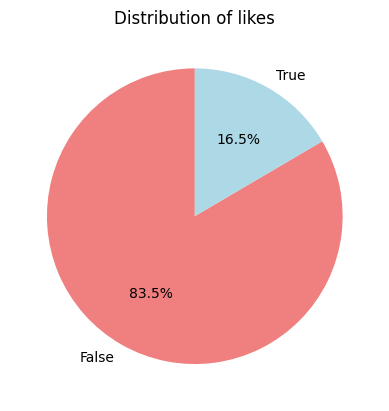

In [7]:
like_counts = train_data["is_like"].value_counts()

plt.pie(like_counts, labels = like_counts.index, autopct="%1.1f%%", startangle=90, colors=["lightcoral", "lightblue"])
plt.title("Distribution of likes")
plt.show()

Below we can see the number of "likes" per user. We immediately observe that there are largely 2 types of users: users that engage with the platform regularly (say those with more than 15 likes) and the majority of users that engage more casually with the platform. We will have a harder time predicting values for users that do not have a lot of entries, but this will be addressed in the pre-processing phase.

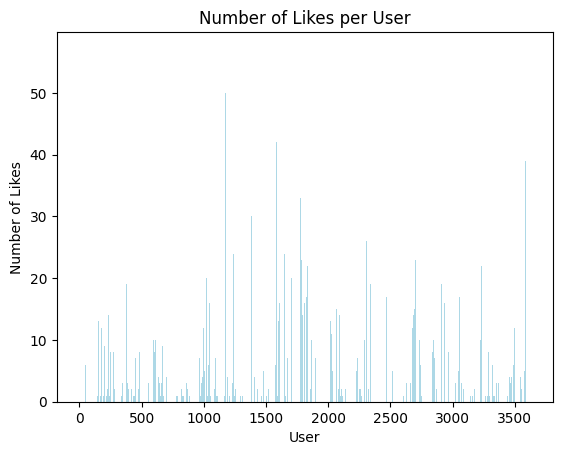

In [8]:
user_like_counts = train_data.groupby("user_to_id")["is_like"].sum()

plt.bar(user_like_counts.index, user_like_counts.values, color = "lightblue")
plt.title("Number of Likes per User")
plt.xlabel("User")
plt.ylabel("Number of Likes")
plt.xticks(rotation = 0)
plt.show()

To get a sense of the density of our dataset, we plot a heatmap of user interactions. It is obvious that our data is very sparse, but still, we can draw some conclusions about our users. We see below that at around ID 2500, user interactions start dropping significantly. This may be due to inactive users, bots, or simply users that installed the app and uninstalled it after a short time.

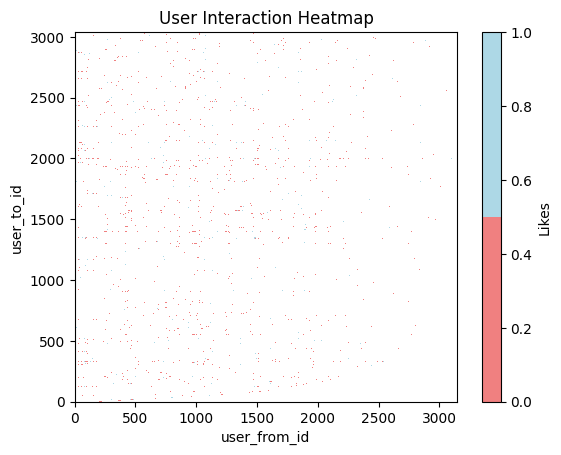

In [9]:
heatmap_data = train_data.pivot_table(index = "user_to_id", columns = "user_from_id", values = "is_like")

colours = ["lightcoral", "lightblue"]
cmap = ListedColormap(colours)

plt.imshow(heatmap_data, cmap = cmap, interpolation = "nearest", origin = "lower")
plt.colorbar(label = "Likes")
plt.xlabel("user_from_id")
plt.ylabel("user_to_id")
plt.title("User Interaction Heatmap")

plt.show()

### Preprocessing Data

We may have a problem with users that haven't interacted enough on the website. The less information we have about an individual, the more difficult our task of recommending them something they may like. Let's see how many users only have one entry in our dataset.

In [10]:
user_value_counts = train_data["user_to_id"].value_counts()
users_one_entry = train_data[train_data["user_to_id"].isin(user_value_counts[user_value_counts == 1].index)]["is_like"]

users_one_entry

702      False
1310     False
1463     False
2259     False
2580     False
         ...  
72091    False
73783    False
74468    False
74648    False
74756    False
Name: is_like, Length: 157, dtype: bool

In [11]:
users_one_entry.value_counts()

is_like
False    132
True      25
Name: count, dtype: int64

Above we can observe that we have relatively few users with only one entry. Nonetheless, we can not ensure that our recommendation will be up to our standard, so we will remove them from the dataset before we apply our algorithm.

In [12]:
train_data.drop(users_one_entry.index)

,user_from_id,user_to_id,is_like
0,1136,3141,False
1,2424,3174,False
2,1300,3590,False
3,800,2736,False
4,883,437,False
...,...,...,...
76387,2376,3057,False
76388,1163,933,False
76389,2770,3324,False
76390,879,785,False


Let's proceed with the final step in preprocessing the data: removing duplicates. 

There may be cases where a user has encountered the same person more than once. This is a problem for us if, for example, the user first liked the person shown, then later changed their mind and gave them a dislike. This can of course happen more than once, introducing a lot of confusion in our dataset. Since we do not have temporal data, we can not just keep the latest decision made by the user (we do not know whether the order of entries in the dataset is the same as the order in which they happened in real life). Therefore, we chose to remove all (user_from_id, user_to_id) duplicate pairs in the dataset before applying our algorithm.

In [13]:
print(train_data.shape[0])

train_data = train_data.drop_duplicates(["user_from_id", "user_to_id"], keep = False)

print(train_data.shape[0])

76392
67895


Now we can finally apply our algorithm: we will create a utility matrix (an adjacency matrix) with user IDs as rows and columns, and for values we have the "is_like" column, or if the pair does not appear in our dataset.

In [14]:
utility_matrix = pd.pivot_table(train_data, values = "is_like", 
                                index = "user_from_id", columns = "user_to_id", dropna = False, fill_value = np.nan)

We now apply nmf with 800 components and 1000 iterations. We have chosen this combination after extensive testing. Please see below other combinations we have tried and the resulting error, and also the number of rows that have a value above our threshold.

(n_components, iterations) => (error, rows above threshold)

(120, 2000) => (6270, 332)
(130, 3000) => (6060, 410)
(200, 3000) => (4824, 388)
(300, 3000) => (3590, 1297)
(500, 1000) => (2075, 7063)

Our best combination (which you can also see in the cells below):

(800, 1000) => (859, 10113)

Please do not rerun this cell as it will take a considerable amount of time.

In [15]:
W, H, E = nmf(utility_matrix, 800)

In [16]:
E

859.1541190039427

To find out how many likes our model has predicted, first we reconstruct the matrix, then we normalize the data so that all values lie between 0 and 1. 

We have set 0.5 as our threshold. We chose this threshold because it sits in the middle of the interval of numbers our values can take. This means that, given a good reconstruction, the number of values above 0.5 should be respect the distribution of the data we analyzed earlier, and indeed we see that it does. Earlier we saw that roughly 16.5% of entries are likes, and in our reconstruction about 15% of entries are likes. This can be improved by tuning hyperparameters to yield a better reconstruction.

In [17]:
res = W @ H 

res = res / np.amax(res)

res[np.where(res > 0.5)].size

10113

### Min-Hashing


We chose to interpret min-hashing like this: 2 users are similar if they liked the same people and is_match is not taken into account.

The HashFunction class represents a hash function used in the minhashing algorithm. It generates a pair of random coefficients (alpha and beta) during initialization

The compute_signature function is responsible for generating the signature matrix. It takes a list of hash functions (hashes) and a binary matrix (binary_matrix) representing user likes. The function iterates through each row and column of the binary matrix, updating the signature matrix with the minimum hash values obtained from the hash functions. The resulting matrix captures the essential features of user preferences.

The jaccard_similarity function calculates the Jaccard similarity between two columns of a signature matrix while excluding np.inf values. It computes the ratio of matching non-infinite hash values to the total number of non-infinite hash values.

The find_nearest_users function identifies the top-k users most similar to a given user based on Jaccard similarity. It takes a target user ID, the number of neighbors to retrieve (k), a Jaccard similarity threshold, the signature matrix, and a mapping of user IDs to indices. The function calculates Jaccard similarities with all other users, filters based on the specified threshold, and returns the top-k similar users for the target user.

In [19]:
class HashFunction:
    
    def __init__(self, p):
        self.alpha = np.random.randint(1, p)
        self.beta = np.random.randint(1, p)

    def hashf(self, x, n):
        hash_value = (self.alpha * x + self.beta) % n
        return hash_value
    
def compute_signature(hashes, binary_matrix):
    num_hashes = len(hashes)
    num_rows, num_columns = binary_matrix.shape

    # Initialize signature matrix with large values
    sig = np.full((num_hashes, num_columns), np.inf)

    # Iterate through each row
    for row_index in range(num_rows):
        # Iterate through each column
        for col_index in range(num_columns):
            # Check if the column has 1 in the current row
            if binary_matrix[row_index, col_index] == 1:
                # Update signature using hash functions
                for hash_index, hash_func in enumerate(hashes):
                    hash_value = hash_func.hashf(row_index, num_rows)
                    if hash_value < sig[hash_index, col_index]:
                        sig[hash_index, col_index] = hash_value

    return sig
    

def jaccard_similarity(column1, column2):
    # Exclude np.inf values from the comparison
    valid_indices = np.isfinite(column1) & np.isfinite(column2)
    
    if not np.any(valid_indices):
        # Handle the case where there are no valid indices
        return 0.0
    
    # Count the number of matching hash values
    matching_hashes = np.sum((column1[valid_indices] == column2[valid_indices]) & valid_indices)
    
    # Count the total number of valid hash values
    total_hashes = np.sum(valid_indices)
    
    # Calculate Jaccard similarity
    similarity = matching_hashes / total_hashes
    
    return similarity

def find_nearest_users(user_id, k, threshold, signature_matrix, user_id_to_index):
    user_index = user_id_to_index[user_id]

    # Calculate Jaccard similarity with all other users
    similarities = [
        (other_user_id, jaccard_similarity(signature_matrix[:, user_index], signature_matrix[:, other_user_index]))
        for other_user_id, other_user_index in user_id_to_index.items() if other_user_id != user_id
    ]

    # Filter users based on the threshold
    similar_users = [(other_user_id, similarity) for other_user_id, similarity in similarities if similarity >= threshold]

    # Sort by similarity and take top-k
    similar_users.sort(key=lambda x: x[1], reverse=True)
    top_k_similar_users = similar_users[:k]

    return top_k_similar_users


The code below reads data from a CSV file, processes it to identify unique users, creates a mapping from original user IDs to consecutive indices, initializes a binary matrix based on the number of unique users, and fills in the matrix with information about user preferences (likes) from the original data.

In [20]:
train_data = pd.read_csv(train_file_path, delimiter=',')
# Identify unique users
user_ids = sorted(set(train_data['user_from_id'].unique()) | set(train_data['user_to_id'].unique()))

# Create a dictionary to map original user IDs to consecutive indices
user_id_to_index = {user_id: i for i, user_id in enumerate(user_ids)}

# Initialize the binary matrix
n = len(user_ids)
user_likes_matrix = np.zeros((n, n), dtype=int)

# Fill in the matrix based on the 'is_like' column
for _, row in train_data.iterrows():
    from_user_index = user_id_to_index[row['user_from_id']]
    to_user_index = user_id_to_index[row['user_to_id']]
    user_likes_matrix[to_user_index, from_user_index] = 1 if row['is_like'] else 0

After some testing with the outputs, 100 seems to be a reasonable number of hash functions. Also, a threshold of 0.8 is used for the similarity. The problem with our interpretation of the data is that most users are not really active and most is_liked column values are false. Thus, it is not feasible for most users to have other users recommended to them. The recommendations below show this fact.

In [21]:
num_hashes = 100
p = 999983  # Prime number greater than number of users
hash_functions = [HashFunction(p) for _ in range(num_hashes)]

signature_matrix = compute_signature(hash_functions, user_likes_matrix)

k = 5
threshold = 0.8

for user_id in user_ids:
    # Find nearest users based on Jaccard similarity
    nearest_users = find_nearest_users(user_id, k, threshold, signature_matrix, user_id_to_index)
    
    # Extract user IDs from the indices
    recommended_user_ids = [other_user_id for other_user_id, _ in nearest_users]
    
    # Print the user ID and recommended user IDs
    print(f"User {user_id} recommendations: {recommended_user_ids}")

User 0 recommendations: []
User 1 recommendations: []
User 2 recommendations: [1247, 3020, 3674]
User 3 recommendations: []
User 4 recommendations: []
User 5 recommendations: []
User 6 recommendations: []
User 7 recommendations: []
User 8 recommendations: []
User 9 recommendations: []
User 10 recommendations: []
User 11 recommendations: []
User 12 recommendations: []
User 14 recommendations: []
User 15 recommendations: []
User 16 recommendations: []
User 17 recommendations: []
User 18 recommendations: []
User 19 recommendations: []
User 20 recommendations: []
User 21 recommendations: []
User 22 recommendations: []
User 23 recommendations: []
User 24 recommendations: []
User 25 recommendations: []
User 26 recommendations: []
User 27 recommendations: []
User 28 recommendations: []
User 29 recommendations: []
User 30 recommendations: [3038]
User 31 recommendations: []
User 32 recommendations: []
User 33 recommendations: []
User 34 recommendations: [55, 170, 623]
User 35 recommendations: [